In [40]:
import re
import os
import gc
import datetime

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors #  implements word vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.cm as cm

import spacy

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
df = pd.read_csv('/kaggle/input/email-spam-detection-dataset-classification/spam.csv', encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [51]:
df['target'] = [1 if v == 'spam' else 0 for v in df['v1']]
# print(df['v1'].unique())
df = df.drop_duplicates().reset_index(drop=True)
print(df.shape)
df.head()

(5169, 6)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,target
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,1
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,0


In [52]:
# Contractions. Source http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [53]:
# Stop-words
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

stop_words = stop_words.difference(negations)

In [54]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [55]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [56]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def normalize_text(raw_review):

    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >

    # Remove emails
    text = re.sub("\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end

    # remove links
    text = re.sub("https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //,
                                                    # any char 0-unlimited, whitespaces in the end

     # Convert to lower case, split into individual words
    text = text.lower().split()

    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word
            for word in text]

    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()

    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)

    # Remove non-letters
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])

    # Remove excesive whitespaces
    text = re.sub("[\s]+", " ", text)
    # Join the words back into one string separated by space, and return the result.
    return(text)

In [57]:
# Slicing dataset for demonstrative purposes

# df = df.groupby('target').sample(650, random_state=42).reset_index(drop=True)

# Note: without resetting an index we slice over the original Id`s
df.shape

(5169, 6)

In [58]:
df['text_normalized'] = df['v2'].progress_apply(normalize_text)

  0%|          | 0/5169 [00:00<?, ?it/s]

In [59]:
df = df[['text_normalized', 'target']]
df.head()

,text_normalized,target
0,go jurong point crazy available bugis great wo...,0
1,ok lar joke wif oni,0
2,free entry wkly comp win fa cup final tkts st ...,1
3,dun say early hor already say,0
4,nah not think go usf live around though,0


# Building a model

In [61]:
train_idxs = df.sample(frac=0.8, random_state=42).index
test_idxs = [idx for idx in df.index if idx not in train_idxs]

X_train = df.loc[train_idxs, 'text_normalized']
X_test = df.loc[test_idxs, 'text_normalized']

y_train = df.loc[train_idxs, 'target']
y_test = df.loc[test_idxs, 'target']

In [62]:
# Оцінка розподілу цільової змінної в навчальній вибірці
print("Розподіл цільової змінної в навчальній вибірці:")
print(y_train.value_counts(normalize=True))  # Частка кожного класу

# Оцінка розподілу цільової змінної в тестовій вибірці
print("\nРозподіл цільової змінної в тестовій вибірці:")
print(y_test.value_counts(normalize=True))

# Додатково: Перевірка загального розподілу цільової змінної
print("\nРозподіл цільової змінної у всьому датасеті:")
print(df['target'].value_counts(normalize=True))

Розподіл цільової змінної в навчальній вибірці:
target
0    0.870375
1    0.129625
Name: proportion, dtype: float64

Розподіл цільової змінної в тестовій вибірці:
target
0    0.886847
1    0.113153
Name: proportion, dtype: float64

Розподіл цільової змінної у всьому датасеті:
target
0    0.87367
1    0.12633
Name: proportion, dtype: float64


In [63]:
vect = CountVectorizer().fit(X_train)
len(vect.vocabulary_) # підраховує кількість унікальних слів (розмір словника)

6403

In [65]:
vect.get_feature_names_out()[:15] # приклад ознак   

array(['aah', 'aaooooright', 'aathilove', 'ab', 'abbey', 'abeg', 'abel',
       'aberdeen', 'abi', 'ability', 'abiola', 'abj', 'able',
       'abnormally', 'about'], dtype=object)

In [66]:
# Перетворимо навчальні дані на матрицю документ-термін (document-term matrix).
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.shape

(4135, 6403)

In [67]:
X_train_vectorized

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 33978 stored elements and shape (4135, 6403)>

In [68]:
# Розріджена матриця — це тип матриці, в якій більшість елементів є нулями.
X_train_vectorized[:,0].todense()

matrix([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [69]:
model = LogisticRegression(random_state=42)
model.fit(X_train_vectorized, y_train)

LogisticRegression(random_state=42)

In [71]:
# Розрахуємо точність моделі.
predictions = model.predict(vect.transform(X_test))
print('Accuracy: ', accuracy_score(y_test, predictions))
print('AUC: ', roc_auc_score(y_test, predictions))

Accuracy:  0.9816247582205029
AUC:  0.922531666806476


In [100]:
# Для подальшого швидкого тестування різних варіантів обробки даних напишемо допоміжну функцію.
# Алгоритм tf-idf ми розглянемо в наступному підрозділі.

def get_preds(text_column, algorithm, ngrams=(1,1)):

    X_train = df.loc[train_idxs, text_column]
    X_test = df.loc[test_idxs, text_column]

    y_train = df.loc[train_idxs, 'target']
    y_test = df.loc[test_idxs, 'target']

    if algorithm == 'cv':
        vect = CountVectorizer(ngram_range=ngrams).fit(X_train)
    elif algorithm == 'tfidf':
        vect = TfidfVectorizer(ngram_range=ngrams).fit(X_train)
    else:
        raise ValueError('Select correct algorithm: `cv` or `tfidf`')

    print('Vocabulary length: ', len(vect.vocabulary_))

    # transform the documents in the training data to a document-term matrix

    X_train_vectorized = vect.transform(X_train)
    print('Document-term matrix shape:', X_train_vectorized.shape)

    model = LogisticRegression(random_state=42)
    model.fit(X_train_vectorized, y_train)

    predictions = model.predict(vect.transform(X_test))

    print('Accuracy: ', accuracy_score(y_test, predictions))
    print('AUC: ', roc_auc_score(y_test, predictions))
    

In [101]:
# from sklearn.metrics import roc_auc_score, accuracy_score
# from gensim.models import KeyedVectors
# import numpy as np

# def get_preds(text_column, algorithm, ngrams=(1,1), embedding_model=None):
#     # Train-test split
#     X_train = df.loc[train_idxs, text_column]
#     X_test = df.loc[test_idxs, text_column]
#     y_train = df.loc[train_idxs, 'target']
#     y_test = df.loc[test_idxs, 'target']

#     if algorithm in ['cv', 'tfidf']:
#         # Choose vectorizer
#         if algorithm == 'cv':
#             vect = CountVectorizer(ngram_range=ngrams).fit(X_train)
#         elif algorithm == 'tfidf':
#             vect = TfidfVectorizer(ngram_range=ngrams).fit(X_train)

#         print('Vocabulary length: ', len(vect.vocabulary_))
#         X_train_vectorized = vect.transform(X_train)
#         X_test_vectorized = vect.transform(X_test)

#     elif algorithm == 'embedding':
#         # Generate embeddings for train and test using pre-trained embedding model
#         if embedding_model is None:
#             raise ValueError('You must provide a pre-trained embedding model for "embedding" algorithm.')

#         def get_avg_embedding(text, model):
#             words = text.split()
#             vectors = [model[word] for word in words if word in model]
#             return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

#         # Transform text data into embeddings
#         X_train_vectorized = np.vstack([get_avg_embedding(text, embedding_model) for text in X_train])
#         X_test_vectorized = np.vstack([get_avg_embedding(text, embedding_model) for text in X_test])
#     else:
#         raise ValueError('Select correct algorithm: `cv`, `tfidf`, or `embedding`')

#     # Train logistic regression model
#     model = LogisticRegression(random_state=42)
#     model.fit(X_train_vectorized, y_train)

#     # Predict and evaluate
#     predictions = model.predict(X_test_vectorized)
#     print('AUC: ', roc_auc_score(y_test, predictions))
#     print('Accuracy: ', accuracy_score(y_test, predictions))

In [102]:
# Використання BoW
get_preds('text_normalized', 'cv')

Vocabulary length:  6403
Document-term matrix shape: (4135, 6403)
Accuracy:  0.9816247582205029
AUC:  0.922531666806476


In [103]:
# Використання TF-IDF
get_preds('text_normalized', 'tfidf')

Vocabulary length:  6403
Document-term matrix shape: (4135, 6403)
Accuracy:  0.9545454545454546
AUC:  0.8066017951514135


In [104]:
get_preds('text_normalized', 'cv', (1,2))

Vocabulary length:  30968
Document-term matrix shape: (4135, 30968)
Accuracy:  0.9748549323017408
AUC:  0.892617136891946


In [105]:
get_preds('text_normalized', 'tfidf', (1,2))

Vocabulary length:  30968
Document-term matrix shape: (4135, 30968)
Accuracy:  0.9497098646034816
AUC:  0.7889625217869494


# From scratch

In [106]:
# Напишемо функцію, яка створює список списків, що містить слова з кожного речення.
# Таким чином ми розбиваємо наші вхідні речення на токени, які буде вивчати модель векторного представлення.
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)

    return corpus

corpus = build_corpus(df['text_normalized'])
corpus[0]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'get',
 'amore',
 'wat']

In [107]:
model_emb_from_scratch = word2vec.Word2Vec(corpus, vector_size=100, window=5, min_count=5, workers=4)

In [108]:
vector = model_emb_from_scratch.wv['text']  # Вектор слова 'learning'
print(vector)  # Виведе вектор як numpy-масив

[-0.23627095  0.42486852 -0.05533745 -0.05781944 -0.00638187 -0.6546773
  0.22295578  0.7777047  -0.33352682 -0.02498204 -0.3952771  -0.51637936
 -0.33402622  0.21226044  0.07729299 -0.2561619   0.22742942 -0.48958716
  0.01928256 -0.7721368   0.34057057  0.16333267  0.17675479 -0.23339993
 -0.27910626  0.01375321 -0.29087916 -0.3504384  -0.37007523  0.2470696
  0.5457762   0.0391895   0.18496127 -0.36221156 -0.13970083  0.4243649
  0.12727809 -0.26958224 -0.29871294 -0.6942294  -0.03430231 -0.19274634
 -0.10549451 -0.1331117   0.27710727 -0.1552089  -0.23563519 -0.07231421
  0.30667025  0.3224602   0.2167307  -0.21568784  0.00521965  0.03555439
 -0.25973478  0.3135252   0.2068678  -0.1256522  -0.43353438  0.17527424
  0.14369029  0.15405917 -0.14250812 -0.20982581 -0.55916625  0.08296704
  0.23746331  0.27070016 -0.4520026   0.4381922  -0.31797135  0.00363704
  0.39914584 -0.19702448  0.3903469   0.33275613  0.0286584   0.04942596
 -0.4638083   0.21761791 -0.34996635 -0.04574986 -0.34

In [109]:
# words = model_emb_from_scratch.wv.index_to_key
# print(words[:20])  # Вивести перші 20 слів

# print(model_emb_from_scratch.vector_size)  # Наприклад, 100

# word = 'machine'
# if word in model_emb_from_scratch.wv:
#     print(f"Слово '{word}' є у моделі.")
# else:
#     print(f"Слово '{word}' відсутнє у моделі.")

similar_words = model_emb_from_scratch.wv.most_similar('claim', topn=5)  # Топ-5 схожих слів
print(similar_words)

[('win', 0.9994753003120422), ('prize', 0.9994010329246521), ('award', 0.9993525743484497), ('call', 0.999323844909668), ('cash', 0.9992427229881287)]


In [110]:
model_emb_from_scratch.wv.save_word2vec_format('/kaggle/working/model_spam_from_scratch.bin', binary=True)

In [111]:
# Load the saved embeddings
loaded_wv = KeyedVectors.load_word2vec_format('/kaggle/working/model_spam_from_scratch.bin', binary=True)

# Check the first few words
print(loaded_wv.index_to_key[:10])  # Print the first 10 words

# Access a vector
print(loaded_wv['claim'])  # Print the

['not', 'get', 'go', 'call', 'no', 'ur', 'come', 'do', 'know', 'ltgt']
[-2.6636234e-01  4.6764493e-01 -4.5139857e-02 -8.2698263e-02
  1.6832450e-02 -7.0474052e-01  2.7664694e-01  8.1920290e-01
 -3.8140923e-01 -1.1742808e-03 -4.3638277e-01 -5.7855505e-01
 -3.4204453e-01  2.0245364e-01  7.3138289e-02 -2.9587018e-01
  2.2404572e-01 -5.1193118e-01  5.1291700e-04 -8.2592750e-01
  3.8034207e-01  1.7781489e-01  1.5986304e-01 -2.3022467e-01
 -3.0149764e-01 -1.0714109e-02 -2.8361252e-01 -3.5801968e-01
 -4.2073855e-01  2.6559597e-01  5.9277159e-01  2.1590246e-02
  2.0940109e-01 -3.8174585e-01 -1.7610048e-01  4.6671629e-01
  1.4750060e-01 -2.8777155e-01 -3.0193964e-01 -7.6288533e-01
 -5.9739109e-02 -2.1340089e-01 -1.1249548e-01 -1.3684553e-01
  3.0696675e-01 -1.4480649e-01 -2.3326454e-01 -6.7163557e-02
  2.9756433e-01  3.5660619e-01  2.5339061e-01 -2.6778504e-01
  2.5303799e-03 -6.4060823e-03 -2.7872598e-01  3.4568644e-01
  1.9433902e-01 -1.6580413e-01 -4.9730721e-01  1.5018016e-01
  1.5443754e-0

In [112]:
# Створимо клас для роботи з попередньо навченими представленнями векторів.
class WordEmbedding:

    def __init__(self):
        self.model = {}

    def convert(self, source, ipnut_file_path, output_file_path):
        '''
        Converts word embeddings from GloVe format to Word2Vec format
        '''
        if source == 'glove':
            glove2word2vec(ipnut_file_path, output_file_path)
        elif source in ['word2vec', 'fasttext', 'from_scratch']:
            pass
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

    def load(self, source, file_path):
        '''
        Loads a specified word embedding model from a file
        '''
        print(datetime.datetime.now(), 'start: loading', source)
        if source in ['glove', 'fasttext']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path)
        elif source in ['word2vec', 'from_scratch']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        print(datetime.datetime.now(), 'end: loading', source)

        return self

    def get_model(self, source):
        '''
        Retrieves the loaded word embedding model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        return self.model[source]

    def get_words(self, source, size=None):
        '''
        Retrieves a list of words from the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if size is None:
            return [w for w in self.get_model(source=source).key_to_index]
        else:
            results = []
            for i, word in enumerate(self.get_model(source=source).key_to_index):
                if i >= size:
                    break
                results.append(word)
            return results

        return Exception('Unexpected flow')

    def get_dimension(self, source):
        '''
        Retrieves the dimension of word vectors in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        return self.get_model(source=source).vectors[0].shape[0]

    def get_vectors(self, source, words=None):
        '''
        Retrieves vectors for specified words or for all words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if words is None:
            words = self.get_words(source=source)

        embedding = np.empty((len(words), self.get_dimension(source=source)), dtype=np.float32)
        for i, word in enumerate(words):
            embedding[i] = self.get_vector(source=source, word=word)

        return embedding

    def get_vector(self, source, word):
        '''
        Retrieves the vector representation of a single word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source][word]
        except KeyError as e:
            dims = self.model[source][0].shape
            vect = np.empty(dims)
            vect[:] = np.nan
            return vect

    def get_synonym(self, source, word, topn=5):
        '''
        Retrieves synonyms for a given word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source].most_similar(positive=word, topn=topn)
        except KeyError as e:
            raise

    def get_distance_between_two_words(self, source, word1, word2):
        '''
        Calculates cosine similarity between two words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)

        try:
            return self.model[source].similarity(word1, word2)
        except KeyError as e:
            raise

In [113]:
# Створимо змінні, які будуть зберігати посилання на ваги претренованих векторів (pre-trained word vectors).
fasttext_file_path = '/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
downloaded_glove_file_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
word2vec_file_path = '/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin'
from_scratch_file_path = '/kaggle/working/model_spam_from_scratch.bin'
glove_file_path = '/kaggle/working/glove.6B.300d.vec'

In [114]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

def get_preds_embeddings(text_column, embedding_model):
    """
    Класифікація текстових даних за допомогою попередньо навчених ембедингів.

    Parameters:
        text_column (str): Назва колонки з текстовими даними.
        embedding_model (gensim.models.KeyedVectors): Попередньо навчена модель ембедингів.
    """

    # Розподіл даних
    X_train = df.loc[train_idxs, text_column]
    X_test = df.loc[test_idxs, text_column]

    y_train = df.loc[train_idxs, 'target']
    y_test = df.loc[test_idxs, 'target']

    # Функція для отримання середнього ембедингу для тексту
    def get_avg_embedding(text, model):
        words = text.split()  # Розділення тексту на слова
        vectors = [model[word] for word in words if word in model]  # Ембединг для кожного слова
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)  # Середній вектор або нульовий

    # Генерація ембедингів для навчального і тестового наборів
    X_train_vectorized = np.vstack([get_avg_embedding(text, embedding_model) for text in X_train])
    X_test_vectorized = np.vstack([get_avg_embedding(text, embedding_model) for text in X_test])

    print('Training data shape:', X_train_vectorized.shape)
    print('Testing data shape:', X_test_vectorized.shape)

    # Побудова логістичної регресії
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_vectorized, y_train)

    # Передбачення та оцінка
    predictions = model.predict(X_test_vectorized)
    print('Accuracy: ', accuracy_score(y_test, predictions))
    print('AUC: ', roc_auc_score(y_test, predictions))

In [119]:
# Використання попередньо навчених ембедингів
embedding_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)
get_preds_embeddings('text_normalized', embedding_model)

Training data shape: (4135, 300)
Testing data shape: (1034, 300)
Accuracy:  0.9410058027079303
AUC:  0.798968207365154


In [116]:
embedding_model = KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)
get_preds_embeddings('text_normalized', embedding_model)

Training data shape: (4135, 300)
Testing data shape: (1034, 300)
Accuracy:  0.9545454545454546
AUC:  0.8476125231850423


In [ ]:
gc.collect()

In [123]:
word_embedding = WordEmbedding()

In [124]:
word_embedding.convert(source='glove', ipnut_file_path=downloaded_glove_file_path, output_file_path=glove_file_path)

/tmp/ipykernel_30/2441100152.py:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(ipnut_file_path, output_file_path)


In [127]:
# Використання попередньо навчених ембедингів
embedding_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False)
get_preds_embeddings('text_normalized', embedding_model)

Training data shape: (4135, 300)
Testing data shape: (1034, 300)
Accuracy:  0.9429400386847195
AUC:  0.8224282079243911


In [128]:
%%time
word_embedding.load(source='word2vec', file_path=word2vec_file_path)
word_embedding.load(source='glove', file_path=glove_file_path)
word_embedding.load(source='fasttext', file_path=fasttext_file_path)
word_embedding.load(source='from_scratch', file_path=from_scratch_file_path)
# word_embedding.load(source='from_scratch', file_path='/content/drive/MyDrive/ds/saved_models/model_emb_from_scratch.bin')

2024-12-02 03:12:16.180271 start: loading word2vec
2024-12-02 03:12:40.147339 end: loading word2vec
2024-12-02 03:12:40.147434 start: loading glove
2024-12-02 03:13:44.013548 end: loading glove
2024-12-02 03:13:44.013692 start: loading fasttext
2024-12-02 03:18:54.967487 end: loading fasttext
2024-12-02 03:18:54.967702 start: loading from_scratch
2024-12-02 03:18:54.976722 end: loading from_scratch
CPU times: user 6min 31s, sys: 7.47 s, total: 6min 39s
Wall time: 6min 38s


In [129]:
print('from_scratch words: ', word_embedding.get_words(source='from_scratch', size=20))
print('glove words: ', word_embedding.get_words(source='glove', size=20))
print('word2vec words: ', word_embedding.get_words(source='word2vec', size=20))  
print('fasttext words: ', word_embedding.get_words(source='fasttext', size=20)) 

from_scratch words:  ['not', 'get', 'go', 'call', 'no', 'ur', 'come', 'do', 'know', 'ltgt', 'good', 'ok', 'free', 'like', 'send', 'want', 'day', 'time', 'love', 'you']
glove words:  ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
word2vec words:  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']
fasttext words:  [',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The']


In [130]:
# print(len(word_embedding.get_words(source='glove')))  # Check first 10 words
# print(len(word_embedding.get_words(source='from_scratch')))  # Check first 10 words

print('from_scratch len: ', len(word_embedding.get_words(source='from_scratch')))
print('glove len: ', len(word_embedding.get_words(source='glove')))
print('word2vec len: ', len(word_embedding.get_words(source='word2vec')))
print('fasttext len: ', len(word_embedding.get_words(source='fasttext')))

from_scratch len:  1376
glove len:  400000
word2vec len:  3000000
fasttext len:  2000000


In [131]:
# Get vectors слова «reply», використовуючи різні ембединги.

for source in ['glove', 'from_scratch', 'word2vec', 'fasttext']: # 'glove', 'from_scratch', 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_vector(source=source, word='reply'))
    print('Dimension:', len(word_embedding.get_vector(source=source, word='reply')))

Source: glove
[-6.8124e-01 -3.6595e-01 -2.6998e-01 -4.4866e-02 -6.8783e-02 -2.1859e-01
 -1.0279e-01 -5.7510e-01 -2.2746e-01 -8.8896e-01 -1.9133e-02  4.1805e-01
 -3.6128e-02  4.7483e-02  2.9294e-01  3.2102e-01 -2.1718e-01  3.9685e-02
 -2.7197e-01 -4.0357e-01 -1.8977e-01  3.9122e-01  3.7491e-01  1.7947e-01
 -6.9641e-01  9.4246e-02  3.8615e-01 -3.2020e-01  3.3470e-01 -4.5832e-01
 -4.2062e-01 -1.6019e-01 -6.9243e-02 -1.7511e-01 -6.7537e-01 -7.0490e-01
  1.8734e-01 -7.7790e-02 -2.4699e-01  3.8346e-02  3.5626e-02  5.4662e-01
  1.5315e-01  3.7995e-01  1.9954e-01 -1.5893e-01 -1.3153e-01 -3.6604e-01
 -6.5433e-01 -2.0187e-01 -3.7835e-01  2.1021e-02  3.1648e-01  2.4576e-01
 -2.1060e-01  4.1814e-01 -1.3686e-01  4.0601e-01 -1.9192e-01  2.3323e-01
  4.9819e-01 -2.3883e-01 -6.6965e-01 -6.7070e-02  3.2009e-01  1.9148e-01
  6.1839e-01 -4.9479e-01  2.6518e-01  1.0366e-01  5.3715e-01 -2.0777e-03
  3.0439e-01 -1.6650e-01  3.2613e-01  3.7834e-02  3.3067e-02  3.8991e-01
 -1.1833e-02  4.6008e-01 -2.9385e-01 

In [132]:
# У вихідному векторі, отриманому з виклику моделей GloVe і натренованої нами Word2Vec для слова «cat»,
# кожна з 50 (100) координат представляє певні семантичні характеристики цього слова у просторі високої розмірності.

# Виведемо найбільш близькі за значенням до слова «cat» слова.
# Для цього викличемо метод get_synonym, який у свою чергу викликає метод most_similar моделі.
# Метод most_similar використовує косинусну подібність як міру близькості слів у n-мірному просторі.

# Get Most Similar Words

for source in ['from_scratch', 'glove', 'word2vec', 'fasttext']: # 'from_scratch', 'glove', 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_synonym(source=source, word='prize', topn=5))

Source: from_scratch
[('claim', 0.9994009733200073), ('guarantee', 0.9991840124130249), ('win', 0.9991752505302429), ('award', 0.9989268183708191), ('call', 0.9988034963607788)]
Source: glove
[('nobel', 0.7725169062614441), ('prizes', 0.7619473934173584), ('award', 0.6773898005485535), ('laureate', 0.6369465589523315), ('winner', 0.6126947999000549)]
Source: word2vec
[('prizes', 0.7578684091567993), ('Prize', 0.714333713054657), ('grand_prize', 0.6862711906433105), ('Prizes', 0.6373021006584167), ('prizewinners', 0.6185271739959717)]
Source: fasttext
[('prizes', 0.8214598894119263), ('Prize', 0.7672895193099976), ('prize.The', 0.7277222275733948), ('prize.', 0.7213537693023682), ('prize.And', 0.71607905626297)]


In [133]:
# Get Distance (косинусна подібність між двома словами)

w1 = 'prize'
w2 = 'win'

for source in ['from_scratch', 'glove', 'word2vec', 'fasttext']: # 'from_scratch', 'glove', 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_distance_between_two_words(source=source, word1=w1, word2=w2))

Source: from_scratch
0.99917525
Source: glove
0.34749472
Source: word2vec
0.2725683
Source: fasttext
0.5660895


In [139]:
w1 = 'prize'
w2 = 'day'

for source in ['from_scratch', 'glove', 'word2vec', 'fasttext']: # 'from_scratch', 'glove', 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_distance_between_two_words(source=source, word1=w1, word2=w2))

Source: from_scratch
0.997049
Source: glove
0.23099235
Source: word2vec
0.10982429
Source: fasttext
0.18246366


# Візуалізація ембедингів

In [134]:
# Візуалізуємо ряд ключових слів keys і найближчих до них слів, використовуючи алгоритм Word2Vec.
# Для кожного ключового слова знайдемо 10 найближчих слів і відповідні їм вектори.
model = gensim.models.KeyedVectors.load_word2vec_format(from_scratch_file_path, binary=True)

In [135]:
# keys = ['Paris', 'Python', 'Sunday', 'Shakespeare', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
#         'experience', 'financial', 'food', 'iOS', 'release']

keys = ['good', 'day', 'free', 'like', 'love', 'time', 'happy', 'work', 'reach',
        'number', 'night', 'right', 'message', 'friend']

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [136]:
# Підготуємо дані для візуалізації. Будемо переводити наші 300-вимірні вектори у 2-вимірні (параметр n_components).
# perplexity пов’язана з кількістю найближчих сусідів, яка використовується в інших різноманітних алгоритмах навчання.
# Більші набори даних зазвичай вимагають більшого значення perplexity.
# Рекомендованим є значення від 5 до 50. Різні значення можуть призвести до суттєво різних результатів.
# Ми маємо відносно невеликий набір даних розмірності (14, 10, 300), тому встановимо цей показник рівним 10.

# Для кращої глобальної стабільності використаємо ініціалізацію PCA.

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

(14, 10, 2)

In [137]:
embedding_clusters.shape

(14, 10, 100)

In [140]:
# Також створимо функцію для візуалізації та візуалізуємо наші дані.
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))

    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=alpha, label=label, )
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

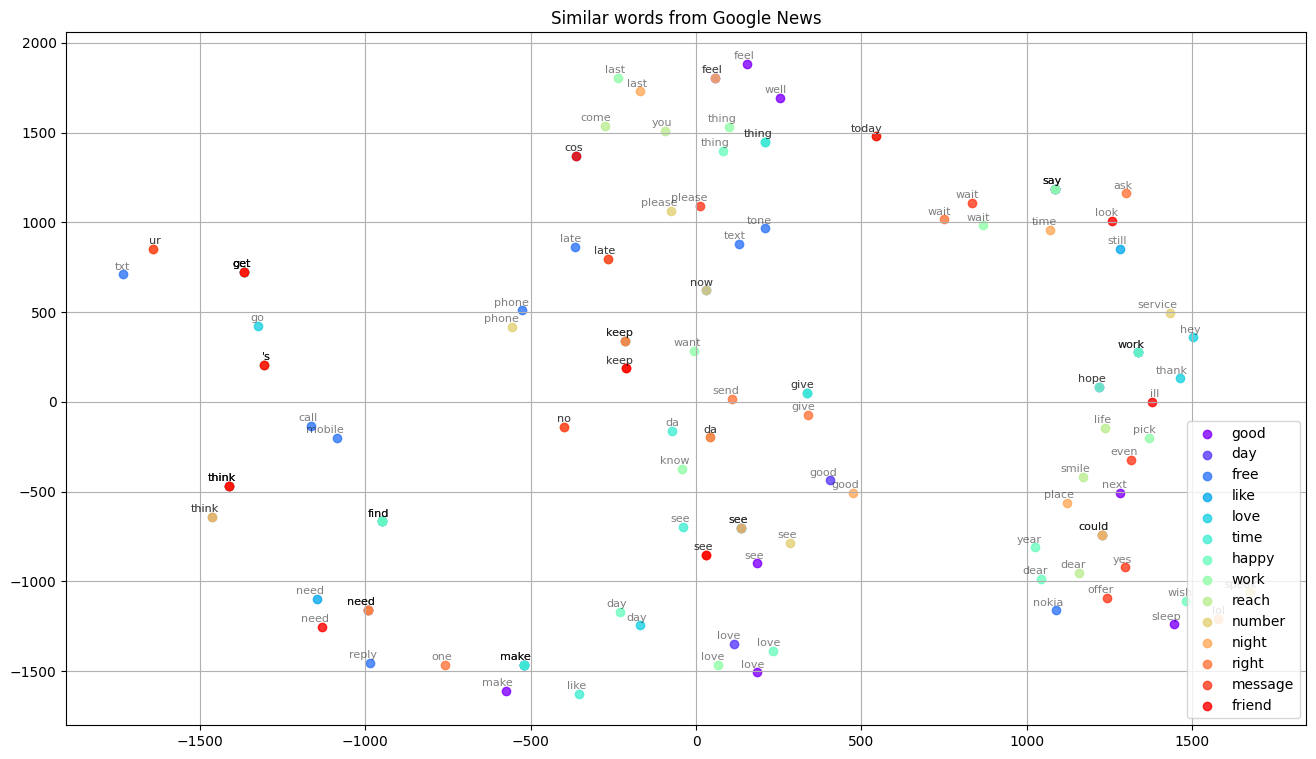

In [141]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

In [142]:
# Repeat for Word2Vec
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

(14, 10, 2)

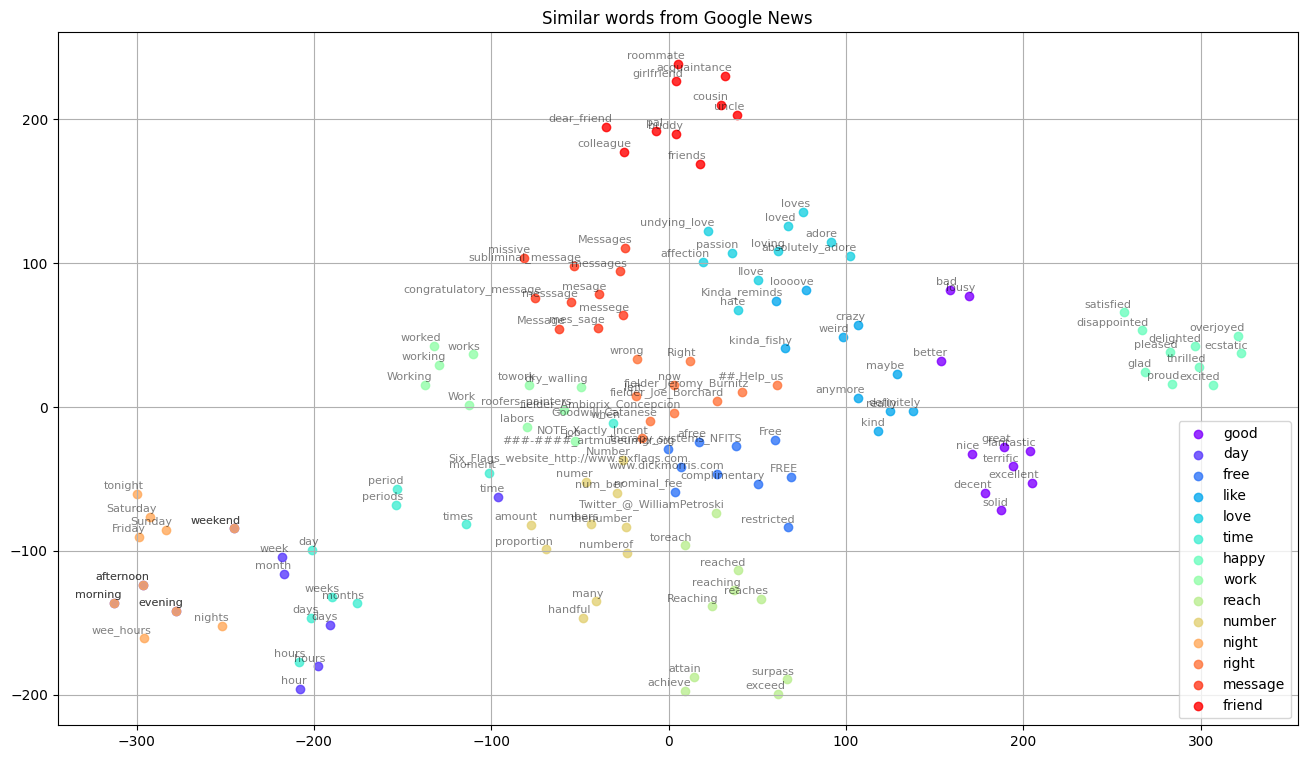

In [143]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

In [144]:
# Repeat for glove
model = gensim.models.KeyedVectors.load_word2vec_format(glove_file_path, binary=False)

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

(14, 10, 2)

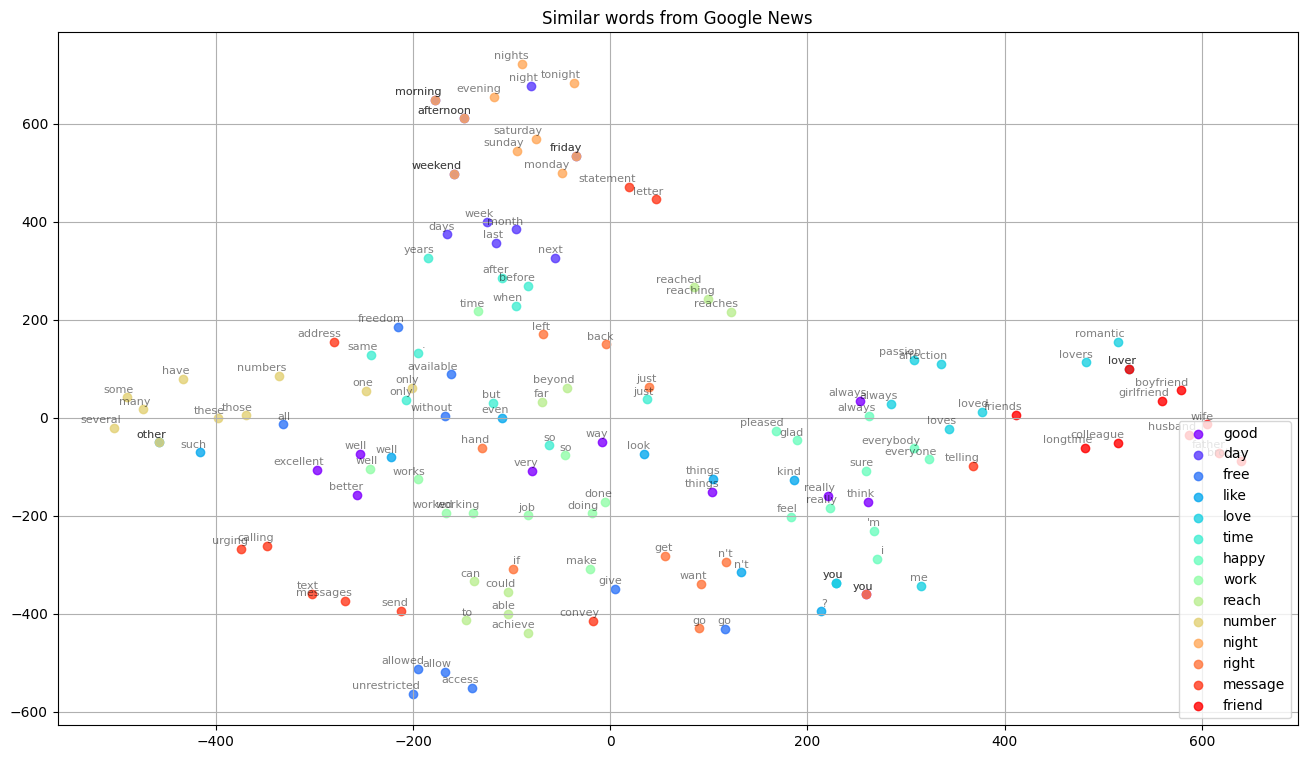

In [145]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

In [148]:
# Repeat for fasttext
model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)

# import fasttext
# import fasttext.util
# # Завантажте FastText модель
# ft_model = fasttext.load_model(fasttext_file_path)
# # Експортуйте у формат Word2Vec
# ft_model.save_model("fasttext_to_word2vec.vec")
# model = KeyedVectors.load_word2vec_format("fasttext_to_word2vec.vec", binary=False)


embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

(14, 10, 2)

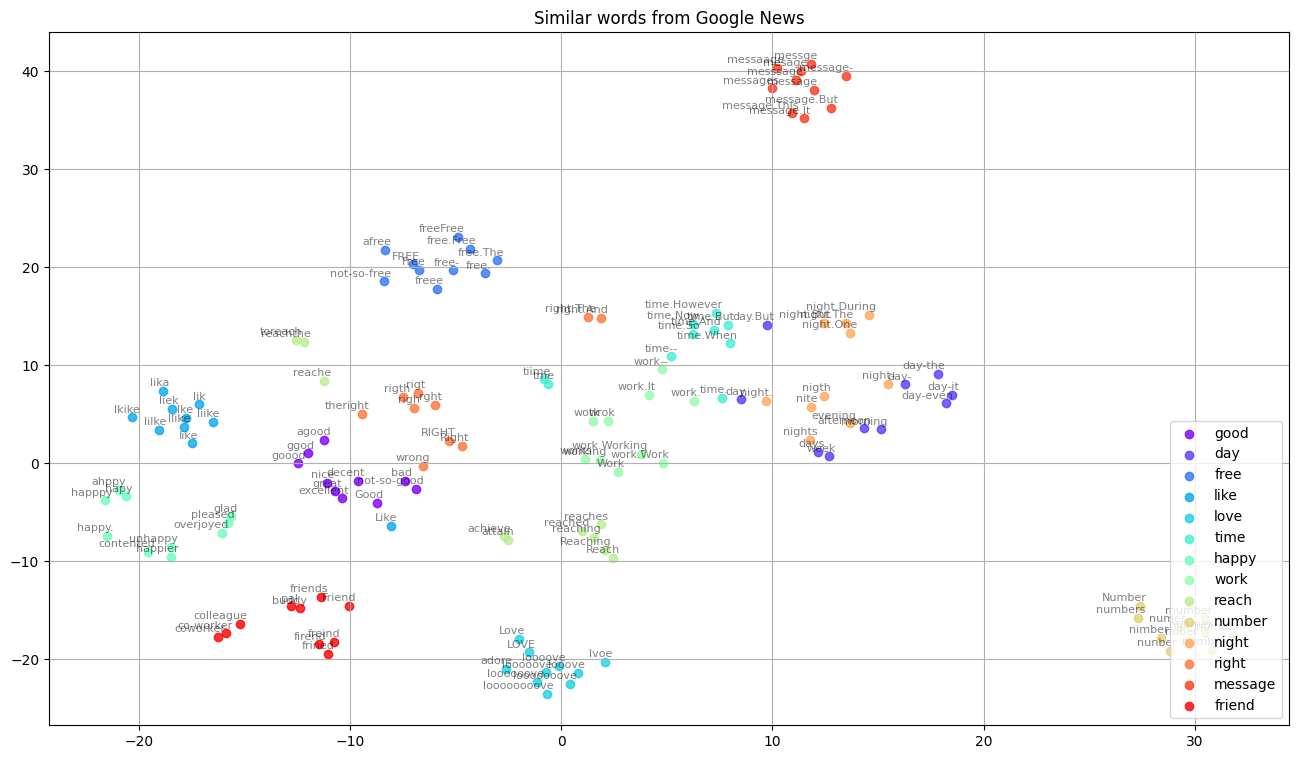

In [149]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

# Аналіз резульатів
1. У датасеті клас 0 становить 87.4%, клас 1 — 12.6%. Дисбаланс між класами значний (але не критичний) що може впливати на метрики якості. Тому більше будемо орієнтуватися на AUC а не Accuracy.

2. Результати моделей з різними методами обробки тексту
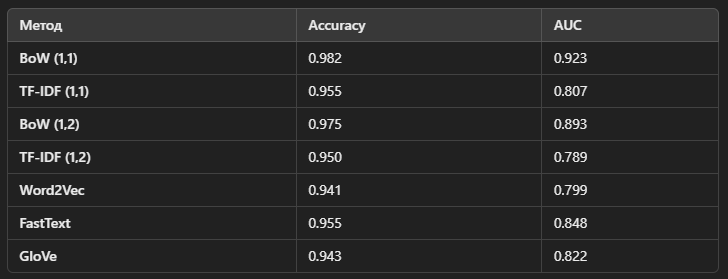

    - BoW (1,1) демонструє найвищу Accuracy та AUC, що свідчить про добру класифікацію навіть при дисбалансі класів.
    - TF-IDF поступається BoW за всіма показниками. Також результати погіршуються при використанні ngrams 1,2 і вище.
    - Попередньо навчені ембеддинги (Word2Vec, FastText, GloVe) дають нижчі результати. З них FastText забезпечує найкращий компроміс між Accuracy (0.955) і AUC (0.848).

3. Косинусна подібність між словами:
    - From Scratch: Найвища подібність між словами (0.999), але це може бути ознакою перенавчання (кожне слово занадто схоже на пов’язані слова).
    - FastText: Середній рівень подібності. Добре захоплює контекст, але не ідеально.
    - GloVe та Word2Vec: Слабка подібність, що може свідчити про слабку відповідність до завдання.


5. Візуалізація векторів

    - From Scratch: Вектори розкидані, чітких кластерів не видно. Це вказує на слабку семантичну структуру в навчанні.
    - Word2Vec: Чітко виділяються кластери, добре розділені за кольорами. Семантичні групи відповідають змісту слів.
    - GloVe: Рівномірний розподіл без кластерів, але антоніми видно за кольорами.
    - FastText: Групи найбільш чіткі. Проте в групах багато схожих за написом слів, та варантів написання. Проте семантику 

# Висновки:
- Простіші методи (BoW, TF-IDF) показали кращі результати, ніж попередньо навчені ембеддинги, ймовірно, через менший розмір даних або невідповідність домену.
- Для семантичних завдань Word2Vec показав найкращу структуру векторів, тоді як FastText найкраще враховує морфологію.
исновки